In [58]:
import gensim
import math
import nltk
import numpy as np
import operator
import pandas as pd
import pickle
import pydotplus
import random
import re
import seaborn as sns
import string
import sys
import time
import warnings
import zipfile

from collections import Counter

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel

from gensim.utils import simple_preprocess
from gensim.utils import simple_preprocess

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from io import StringIO

from IPython.display import Image

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker

from mlxtend.classifier import StackingClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim

from scipy import stats
from scipy.cluster import hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_moons
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support as error_metric
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from string import punctuation

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from wordcloud import STOPWORDS

from xgboost import XGBClassifier
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [85]:
def plot_auc(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def get_results_df(gscv_model,):
    # Creating a dictionary out of the GridSearchCV results
    results_dict = {}
    results = gscv_model.cv_results_
    
    for key in results.keys():
        if type(results[key]) == np.ndarray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == np.ma.core.MaskedArray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == list:
            pass
        else:
            print("Unkown type encountered")
        
    return_df = pd.DataFrame(data=results_dict,)
    
    if return_df.isnull().sum().max() > 0:
        print("Incorrect model training values have been omitted")
        print("{0} values".format(return_df.isnull().sum().max()))
    return_df.dropna(axis=0, inplace=True)
    
    return return_df

def get_scores(model, X_test, y_test,):
    y_pred = model.best_estimator_.predict(X_test,)
    print("Accuracy: {0}".format(accuracy_score(y_test, y_pred,)))
    print("\n")
    print("Recall: {0}".format(recall_score(y_test, y_pred,)))
    print("Precision: {0}".format(precision_score(y_test, y_pred,)))
    print("F1 Score: {0}".format(f1_score(y_test, y_pred,)))
    print("\n")
    print("ROC AUC: {0}".format(roc_auc_score(y_test, y_pred,)))
    print("\n")
    print("Confusion Matrix: \n{0}".format(confusion_matrix(y_test, y_pred,)))
    print("\n")
    print("Classification Report: \n{0}".format(classification_report(y_test, y_pred,)))
    plot_auc(y_test, y_pred)

In [59]:
data = pd.read_csv("processed data/data.csv", index_col=0)

In [60]:
data.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Survived', 'Ticket Shared With',
       'Fare Individual', 'Title', 'Title for Age', 'Cabin Shared With',
       'Ticket Prefix', 'Deck', 'CDensity', 'CD2LF Pop', 'CD2LF Distr',
       'Family Size', 'Title Social'],
      dtype='object')

In [61]:
data.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 
                   'Fare', 'Cabin', 'Embarked', 'Title', 
                   'Title for Age', 'Ticket Prefix', 
                   'Deck'], axis=1, inplace=True)

In [62]:
data = pd.get_dummies(data, columns=['Pclass', 'Sex', 'Title Social'])

In [63]:
data['Age'] = data['Age'].astype(int)

In [64]:
data['Fare Individual'] = data['Fare Individual'].apply(lambda x: round(x, ndigits=2))

In [65]:
data

,Age,Survived,Ticket Shared With,Fare Individual,Cabin Shared With,CDensity,CD2LF Pop,CD2LF Distr,Family Size,Pclass_1,...,Pclass_3,Pclass_4,Sex_female,Sex_male,Title Social_Master,Title Social_Miss,Title Social_Mr,Title Social_Mrs,Title Social_Royalty,Title Social_Sir
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22,0.0,1,7.25,0,2.373239,2.553812,2.178697,2,0,...,0,1,0,1,0,0,1,0,0,0
2,38,1.0,2,35.64,2,0.776442,1.058785,2.704327,2,1,...,0,0,1,0,0,0,0,1,0,0
3,26,1.0,1,7.92,0,2.373239,2.553812,2.178697,1,0,...,0,1,1,0,0,1,0,0,0,0
4,35,1.0,2,26.55,2,0.776442,1.058785,2.704327,2,1,...,0,0,1,0,0,0,0,1,0,0
5,35,0.0,1,8.05,0,3.100000,2.980769,1.953125,1,0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,14,NaN,1,8.05,0,3.100000,2.980769,1.953125,1,0,...,1,0,0,1,0,0,1,0,0,0
1306,39,NaN,3,36.30,1,0.776442,1.058785,2.704327,1,1,...,0,0,1,0,0,0,0,0,1,0
1307,38,NaN,1,7.25,0,3.100000,2.980769,1.953125,1,0,...,1,0,0,1,0,0,1,0,0,0


In [69]:
test_set = data[ data['Survived'].isnull() ].copy()
test_set.drop(columns=['Survived'], axis=1, inplace=True)

In [80]:
train_set = data[ data['Survived'].notnull() ].copy()
train_set['Survived'] = train_set['Survived'].astype(int)

In [81]:
train_set

,Age,Survived,Ticket Shared With,Fare Individual,Cabin Shared With,CDensity,CD2LF Pop,CD2LF Distr,Family Size,Pclass_1,...,Pclass_3,Pclass_4,Sex_female,Sex_male,Title Social_Master,Title Social_Miss,Title Social_Mr,Title Social_Mrs,Title Social_Royalty,Title Social_Sir
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22,0,1,7.25,0,2.373239,2.553812,2.178697,2,0,...,0,1,0,1,0,0,1,0,0,0
2,38,1,2,35.64,2,0.776442,1.058785,2.704327,2,1,...,0,0,1,0,0,0,0,1,0,0
3,26,1,1,7.92,0,2.373239,2.553812,2.178697,1,0,...,0,1,1,0,0,1,0,0,0,0
4,35,1,2,26.55,2,0.776442,1.058785,2.704327,2,1,...,0,0,1,0,0,0,0,1,0,0
5,35,0,1,8.05,0,3.100000,2.980769,1.953125,1,0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,27,0,1,13.00,0,1.709877,2.193922,1.683063,1,0,...,0,0,0,1,0,0,0,0,0,1
888,19,1,1,30.00,1,0.776442,1.058785,2.704327,1,1,...,0,0,1,0,0,1,0,0,0,0
889,20,0,4,5.86,0,2.373239,2.553812,2.178697,4,0,...,0,1,1,0,0,1,0,0,0,0


## Training Pipeline

In [82]:
X, y = train_set.drop('Survived', axis=1, inplace=False), train_set['Survived'].copy()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   stratify=y, random_state=4)

### Logistic Regression

In [89]:
file_name = 'trained models/lr1.pickle'

hyperparameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'C': [0.05, 0.25, 0.7, 1, 2,],
    'class_weight': ['balanced', {0:1, 1:5,}],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter':[1000, 5000,],
    'n_jobs': [-1],
    'l1_ratio': [0.25, 0.4, 0.5, 0.6, 0.75,],
}

scoring = "roc_auc"

model = GridSearchCV(LogisticRegression(random_state=44), hyperparameters, cv=10, 
                     verbose=1, scoring=scoring, 
                     n_jobs=-1, return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    start_time = time.time()

    model.fit(X_train, y_train,)

    time_taken_s = np.around(time.time()-start_time, decimals=2,)
    time_taken_m = time_taken_s/60  
    print('Total Time taken = {0} seconds \nIn minutes: {1}'.format(time_taken_s, time_taken_m,))

    with open(file_name, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Found trained model file with same name. Loading it instead.


In [91]:
get_results_df(model)

Incorrect model training values have been omitted
1200 values


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_l1_ratio,param_max_iter,param_n_jobs,param_penalty,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
2,0.006981,0.002139,0.002792,0.001773,0.05,balanced,0.25,1000,-1,l1,...,0.852936,0.855935,0.858119,0.864592,0.857830,0.866057,0.863886,0.860239,0.860158,0.004281
4,0.313628,0.049421,0.000000,0.000000,0.05,balanced,0.25,1000,-1,l1,...,0.850549,0.852964,0.855848,0.861231,0.855222,0.863759,0.860794,0.858374,0.857454,0.004103
5,0.119167,0.006220,0.000101,0.000302,0.05,balanced,0.25,1000,-1,l2,...,0.872794,0.870117,0.873498,0.880293,0.873128,0.883539,0.879950,0.878422,0.876251,0.004083
6,0.115953,0.004067,0.000301,0.000640,0.05,balanced,0.25,1000,-1,l2,...,0.872808,0.870104,0.873498,0.880280,0.873155,0.883539,0.879950,0.878382,0.876249,0.004079
7,0.005309,0.006991,0.000651,0.001953,0.05,balanced,0.25,1000,-1,l2,...,0.869383,0.868262,0.871791,0.878465,0.871407,0.882209,0.877759,0.875644,0.874156,0.004322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,0.225348,0.037923,0.001817,0.000606,2.00,"{0: 1, 1: 5}",0.75,5000,-1,l2,...,0.885008,0.886759,0.885516,0.894314,0.889165,0.894401,0.891605,0.896645,0.890056,0.003931
1987,0.004616,0.003478,0.001811,0.002281,2.00,"{0: 1, 1: 5}",0.75,5000,-1,l2,...,0.885008,0.886867,0.885610,0.894193,0.889179,0.894428,0.891471,0.896578,0.890052,0.003885
1988,0.373203,0.046627,0.001612,0.000806,2.00,"{0: 1, 1: 5}",0.75,5000,-1,l2,...,0.884779,0.886194,0.885341,0.893736,0.888910,0.893917,0.890637,0.895397,0.889491,0.003738
1989,0.586398,0.043896,0.001608,0.000804,2.00,"{0: 1, 1: 5}",0.75,5000,-1,l2,...,0.884415,0.885267,0.885153,0.893386,0.888668,0.893581,0.890207,0.894740,0.889046,0.003731


Accuracy: 0.8171641791044776


Recall: 0.7961165048543689
Precision: 0.7454545454545455
F1 Score: 0.7699530516431926


ROC AUC: 0.8132097675786997


Confusion Matrix: 
[[137  28]
 [ 21  82]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       165
           1       0.75      0.80      0.77       103

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



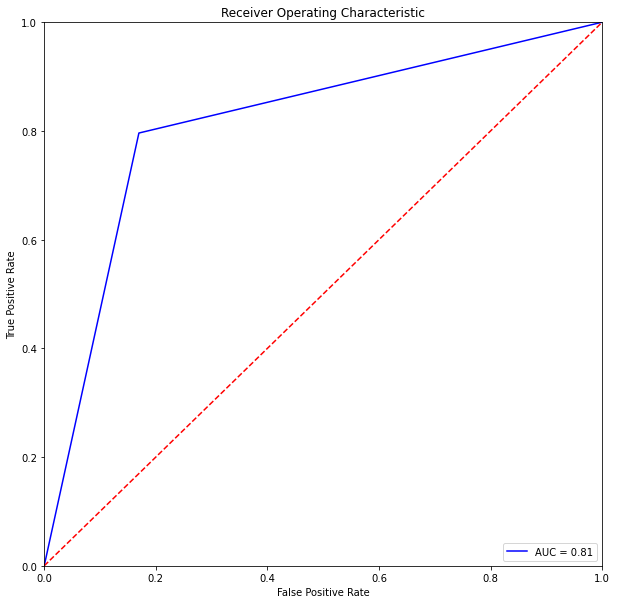

In [92]:
get_scores(model, X_test, y_test,)

In [96]:
results = pd.Series(model.best_estimator_.predict(test_set)).to_frame()

In [99]:
results = pd.DataFrame({
    'PassengerId': test_set.index,
    'Survived': model.best_estimator_.predict(test_set)})
results.to_csv('lr1.csv', index=False)